In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string
# import ray
# ray.init();
import multiprocessing as mp
import copy

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [3]:
C_POS_MAX =  5
C_POS_MIN = -5

C_VEL_MAX =  5
C_VEL_MIN = -5

P_ANG_MAX =  1
P_ANG_MIN = -1

P_VEL_MAX =  5
P_VEL_MIN = -5

In [4]:
GRANULARITY = 50
print("GRANULARITY: ", GRANULARITY)

GRANULARITY:  50


In [5]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [6]:
Q_TABLE = np.zeros((GRANULARITY,
                    GRANULARITY,
                    GRANULARITY,
                    GRANULARITY, 
                    N_ACTIONS))

# Q_TABLE = np.load("./chopped_q_tables/cartpole_nolimit_Q_TABLE_40.npy") 
# Q_TABLE += np.random.uniform(low=-1, high=1.0, size=(GRANULARITY,
#                                                         GRANULARITY,
#                                                         GRANULARITY,
#                                                         GRANULARITY, 
#                                                         N_ACTIONS))*Q_TABLE.std()
c_pos_s = np.linspace(C_POS_MIN, C_POS_MAX, GRANULARITY)
c_vel_s = np.linspace(C_VEL_MIN, C_VEL_MAX, GRANULARITY)
p_ang_s = np.linspace(P_ANG_MIN, P_ANG_MAX, GRANULARITY)
p_vel_s = np.linspace(P_VEL_MIN, P_VEL_MAX, GRANULARITY)

In [7]:
np.save("Q_TABLE_data", Q_TABLE)

In [8]:
state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                GRANULARITY)

In [9]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [10]:
T_LR           = 1e-3
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [11]:
# Hyper Parameters
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.8   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 20000

In [12]:
MAX_NO_OF_ITERATIONS = 25
NN_ITERATIONS    = 20000

In [13]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [14]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [15]:
RFILE = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))+"combo"+str(GRANULARITY)
print("SCRATCH FILE = ", RFILE)

SCRATCH FILE =  STI6WR1Zcombo50


In [16]:
def mp_node_run(node_id):
    my_env = env
    my_env.seed(node_id+iteration)
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195
    
    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        new_Q_TABLE = np.load("Q_TABLE_data.npy")
        my_Q_TABLE  = np.load("Q_TABLE_data.npy")


        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

            s = my_env.reset()
            while True:
                [c_pos_state, 
                c_vel_state, 
                p_ang_state, 
                p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                         c_pos_s, 
                                         c_vel_s, 
                                         p_ang_s, 
                                         p_vel_s)
                time_steps += 1
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1

                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                [next_c_pos_state, 
                next_c_vel_state, 
                next_p_ang_state, 
                next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                              c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

                # learn
                this_state = tuple([c_pos_state, 
                              c_vel_state, 
                              p_ang_state, 
                              p_vel_state])

                next_state = tuple([ next_c_pos_state, 
                               next_c_vel_state, 
                               next_p_ang_state, 
                               next_p_vel_state])

                my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
                                                                         my_Q_TABLE[this_state][a])
                if done:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            #TO LEVEL UP    
            if np.mean(time_rec[-10:]) > level_up_metric:
                PERFECT_RUN_COUNTER += 1
            else:
                PERFECT_RUN_COUNTER = 0

            if PERFECT_RUN_COUNTER > PERFECT_RUNS_HIGH_SCORE:
                PERFECT_RUN_COUNTER = 0
                PERFECT_RUNS_HIGH_SCORE *= 1.5
                my_LR *= 0.1
                if my_EPSILON < 0.99:
                    my_EPSILON += 0.02
            
            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break
    
    exp_rec = np.delete(exp_rec, 0, 0)
    message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
    print(message)
    return exp_rec, time_rec



ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.0
NODE#8 MAIN Q:0.0	NODE Q:5.8481632631113134e-08
NODE#1 MAIN Q:0.0	NODE Q:5.944297666008807e-08
NODE#7 MAIN Q:0.0	NODE Q:5.990553911959065e-08
NODE#9 MAIN Q:0.0	NODE Q:5.869273322047426e-08
NODE#4 MAIN Q:0.0	NODE Q:5.8959157873898185e-08
NODE#2 MAIN Q:0.0	NODE Q:5.9422314183234874e-08
NODE#5 MAIN Q:0.0	NODE Q:5.927108223754602e-08
NODE#0 MAIN Q:0.0	NODE Q:5.952067890383579e-08
NODE#3 MAIN Q:0.0	NODE Q:6.007462747782106e-08
NODE#6 MAIN Q:0.0	NODE Q:5.959105718615439e-08
LARGEST TIMESTEP in ITERATION 0: 12
REAL TIME TO GENERATE 9438 EXPERIENCES:0:00:00.333036


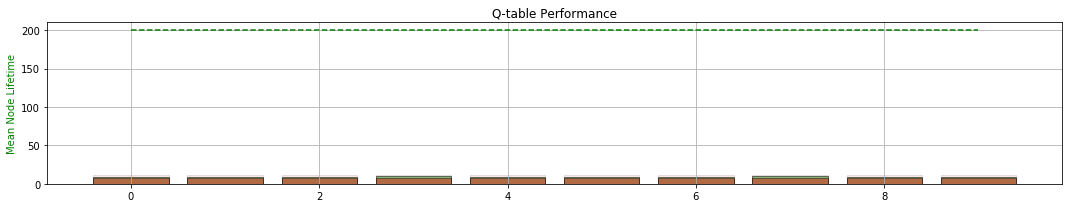

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.525
Validating... MEAN TIME:  9.31
Validating... MEAN TIME:  9.435
Validating... MEAN TIME:  9.43
Validating... MEAN TIME:  9.395
TRAINING TIME:0:00:18.857734


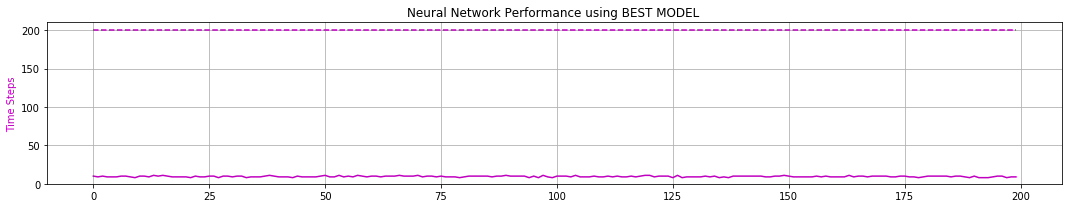

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: -0.05742563


ITERATION # 1
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: -0.05742563
NODE#8 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#6 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#2 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#7 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#4 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#9 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#0 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#1 MAIN Q:-0.05742563	NODE Q:-0.05742558
NODE#5 MAIN Q:-0.05742563	NODE Q:-0.05742557
NODE#3 MAIN Q:-0.05742563	NODE Q:-0.05742557
LARGEST TIMESTEP in ITERATION 1: 14
REAL TIME TO GENERATE 9482 EXPERIENCES:0:00:00.260068


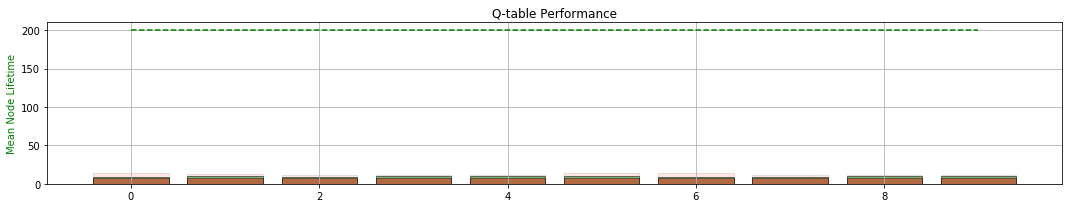

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  64.145
Validating... MEAN TIME:  36.245
Validating... MEAN TIME:  60.41
Validating... MEAN TIME:  61.09
Validating... MEAN TIME:  66.59
TRAINING TIME:0:00:24.399523


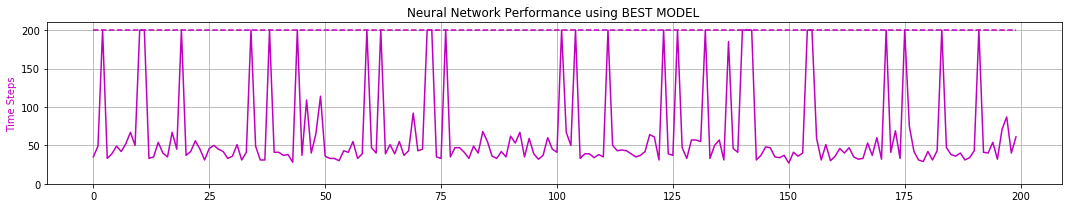

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.059655085


ITERATION # 2
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.059655085
NODE#7 MAIN Q:0.059655085	NODE Q:0.059655495
NODE#6 MAIN Q:0.059655085	NODE Q:0.059655495
NODE#2 MAIN Q:0.059655085	NODE Q:0.059655506
NODE#5 MAIN Q:0.059655085	NODE Q:0.059655506
NODE#3 MAIN Q:0.059655085	NODE Q:0.059655525
NODE#0 MAIN Q:0.059655085	NODE Q:0.059655514
NODE#9 MAIN Q:0.059655085	NODE Q:0.059655514
NODE#1 MAIN Q:0.059655085	NODE Q:0.059655525
NODE#4 MAIN Q:0.059655085	NODE Q:0.059655525
NODE#8 MAIN Q:0.059655085	NODE Q:0.059655555
LARGEST TIMESTEP in ITERATION 2: 176
REAL TIME TO GENERATE 56696 EXPERIENCES:0:00:01.128637


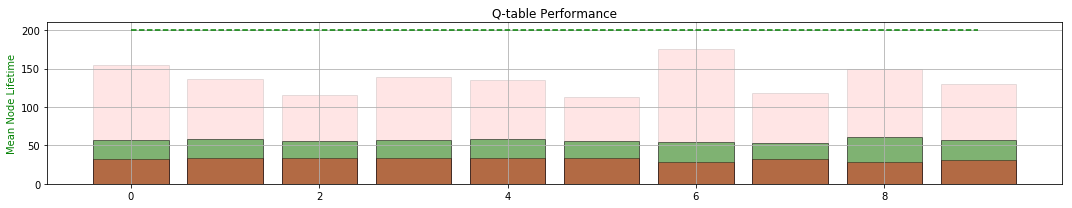

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  175.64
Validating... MEAN TIME:  196.18
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:40.019501


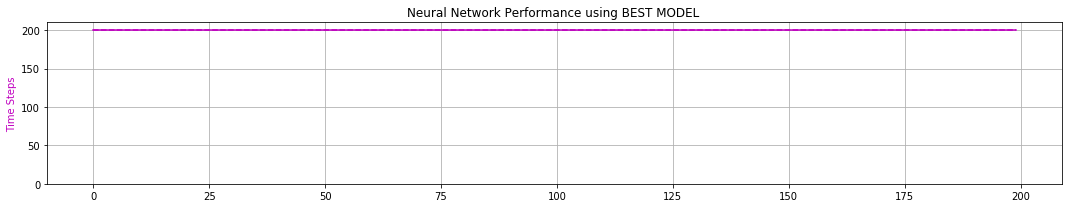

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.15749562


ITERATION # 3
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.15749562
NODE#9 MAIN Q:0.15749562	NODE Q:0.15749708
NODE#4 MAIN Q:0.15749562	NODE Q:0.15749706
NODE#7 MAIN Q:0.15749562	NODE Q:0.1574971
NODE#0 MAIN Q:0.15749562	NODE Q:0.15749708
NODE#3 MAIN Q:0.15749562	NODE Q:0.15749708
NODE#8 MAIN Q:0.15749562	NODE Q:0.15749706
NODE#6 MAIN Q:0.15749562	NODE Q:0.15749708
NODE#2 MAIN Q:0.15749562	NODE Q:0.1574971
NODE#5 MAIN Q:0.15749562	NODE Q:0.1574971
NODE#1 MAIN Q:0.15749562	NODE Q:0.1574971
LARGEST TIMESTEP in ITERATION 3: 200
REAL TIME TO GENERATE 189922 EXPERIENCES:0:00:06.187300


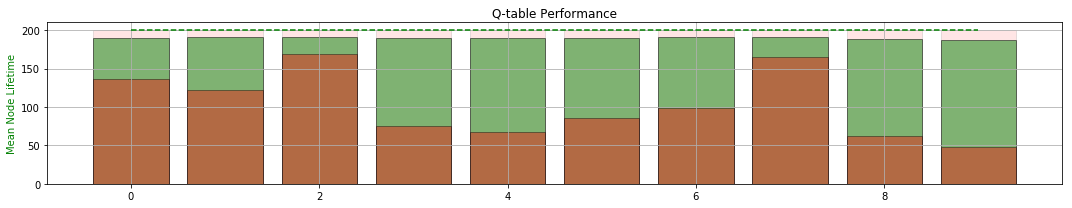

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  165.7
Validating... MEAN TIME:  190.78
Validating... MEAN TIME:  192.695
Validating... MEAN TIME:  189.995
Validating... MEAN TIME:  190.28
TRAINING TIME:0:00:39.478050


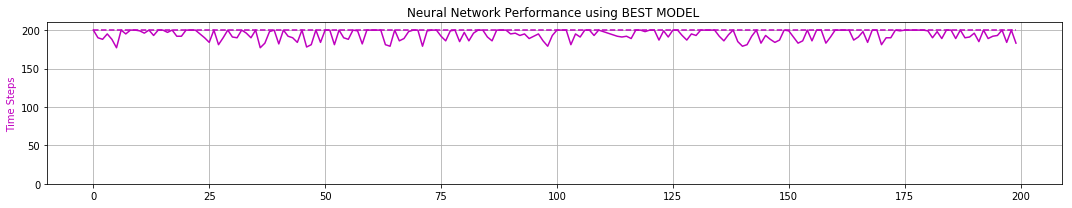

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.4814284


ITERATION # 4
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.4814284
NODE#7 MAIN Q:0.4814284	NODE Q:0.48142952
NODE#8 MAIN Q:0.4814284	NODE Q:0.48142952
NODE#4 MAIN Q:0.4814284	NODE Q:0.4814296
NODE#2 MAIN Q:0.4814284	NODE Q:0.4814296
NODE#6 MAIN Q:0.4814284	NODE Q:0.4814296
NODE#5 MAIN Q:0.4814284	NODE Q:0.48142952
NODE#3 MAIN Q:0.4814284	NODE Q:0.48142952
NODE#9 MAIN Q:0.4814284	NODE Q:0.4814296
NODE#0 MAIN Q:0.4814284	NODE Q:0.4814296
NODE#1 MAIN Q:0.4814284	NODE Q:0.4814296
LARGEST TIMESTEP in ITERATION 4: 169
REAL TIME TO GENERATE 149906 EXPERIENCES:0:00:03.260203


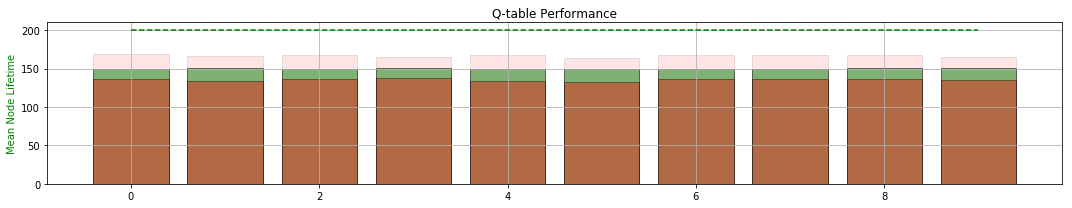

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  177.065
Validating... MEAN TIME:  167.745
Validating... MEAN TIME:  168.52
Validating... MEAN TIME:  159.885
Validating... MEAN TIME:  166.93
TRAINING TIME:0:00:37.394702


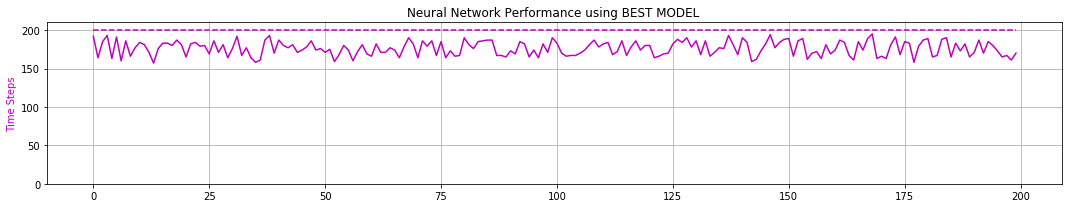

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.45602423


ITERATION # 5
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.45602423
NODE#1 MAIN Q:0.45602423	NODE Q:0.45602527
NODE#0 MAIN Q:0.45602423	NODE Q:0.45602527
NODE#2 MAIN Q:0.45602423	NODE Q:0.45602527
NODE#4 MAIN Q:0.45602423	NODE Q:0.45602524
NODE#6 MAIN Q:0.45602423	NODE Q:0.45602527
NODE#3 MAIN Q:0.45602423	NODE Q:0.45602524
NODE#5 MAIN Q:0.45602423	NODE Q:0.45602524
NODE#9 MAIN Q:0.45602423	NODE Q:0.45602527
NODE#8 MAIN Q:0.45602423	NODE Q:0.45602524
NODE#7 MAIN Q:0.45602423	NODE Q:0.45602524
LARGEST TIMESTEP in ITERATION 5: 150
REAL TIME TO GENERATE 134201 EXPERIENCES:0:00:02.797701


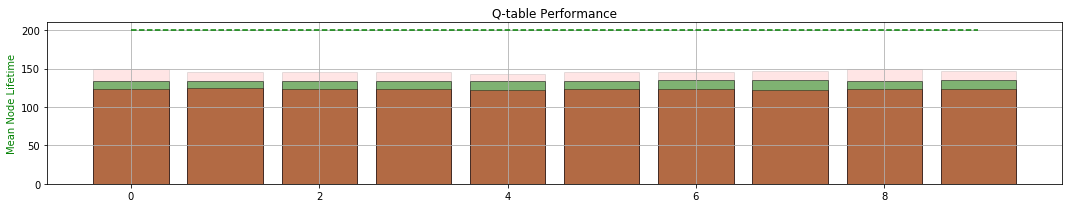

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  163.38
Validating... MEAN TIME:  153.905
Validating... MEAN TIME:  152.77
Validating... MEAN TIME:  149.66
Validating... MEAN TIME:  143.09
TRAINING TIME:0:00:35.796917


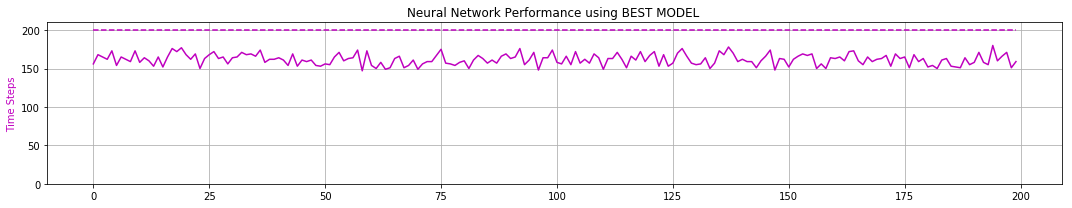

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.39655995


ITERATION # 6
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.39655995
NODE#2 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#0 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#1 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#4 MAIN Q:0.39655995	NODE Q:0.3965609
NODE#6 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#7 MAIN Q:0.39655995	NODE Q:0.3965609
NODE#5 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#9 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#8 MAIN Q:0.39655995	NODE Q:0.39656088
NODE#3 MAIN Q:0.39655995	NODE Q:0.39656088
LARGEST TIMESTEP in ITERATION 6: 138
REAL TIME TO GENERATE 124237 EXPERIENCES:0:00:02.504456


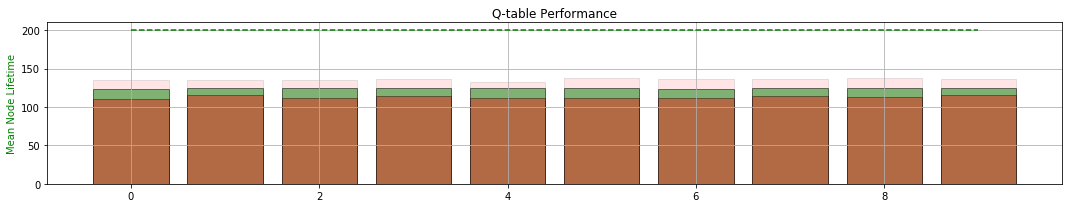

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  151.49
Validating... MEAN TIME:  136.78
Validating... MEAN TIME:  132.93
Validating... MEAN TIME:  130.93
Validating... MEAN TIME:  132.69
TRAINING TIME:0:00:34.627767


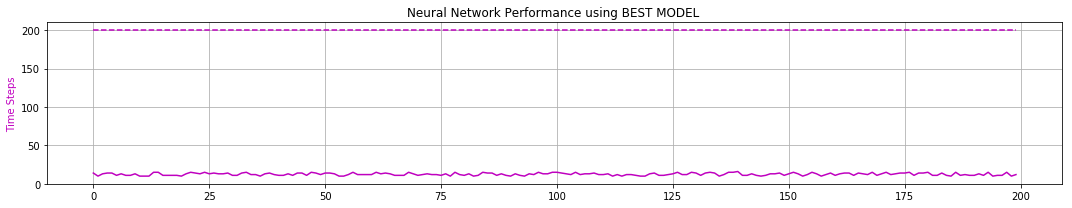

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: -0.20172186


ITERATION # 7
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: -0.20172186
NODE#7 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#9 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#5 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#0 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#2 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#6 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#1 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#4 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#8 MAIN Q:-0.20172186	NODE Q:-0.20172177
NODE#3 MAIN Q:-0.20172186	NODE Q:-0.20172177
LARGEST TIMESTEP in ITERATION 7: 20
REAL TIME TO GENERATE 12804 EXPERIENCES:0:00:00.304455


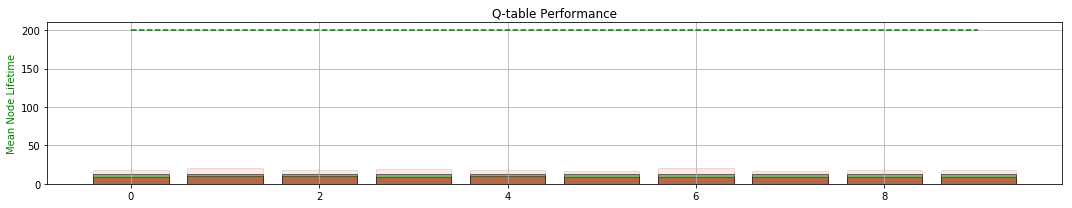

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  28.18
Validating... MEAN TIME:  16.565
Validating... MEAN TIME:  56.3
Validating... MEAN TIME:  46.465
Validating... MEAN TIME:  40.95
TRAINING TIME:0:00:22.654684


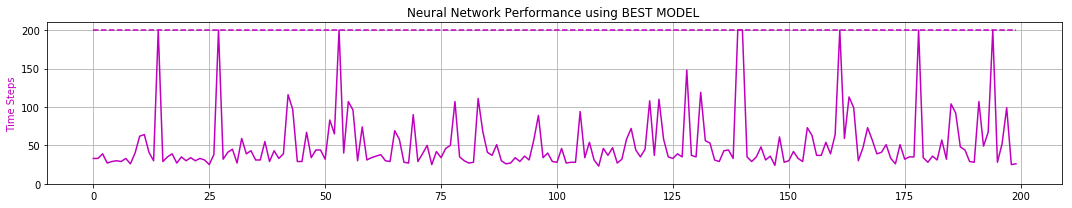

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.38422513


ITERATION # 8
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.38422513
NODE#2 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#9 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#5 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#7 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#8 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#4 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#3 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#6 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#0 MAIN Q:0.38422513	NODE Q:0.38422543
NODE#1 MAIN Q:0.38422513	NODE Q:0.38422543
LARGEST TIMESTEP in ITERATION 8: 177
REAL TIME TO GENERATE 45577 EXPERIENCES:0:00:00.873414


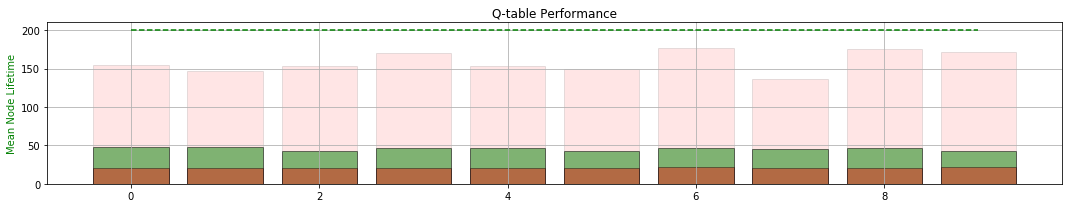

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:43.122258


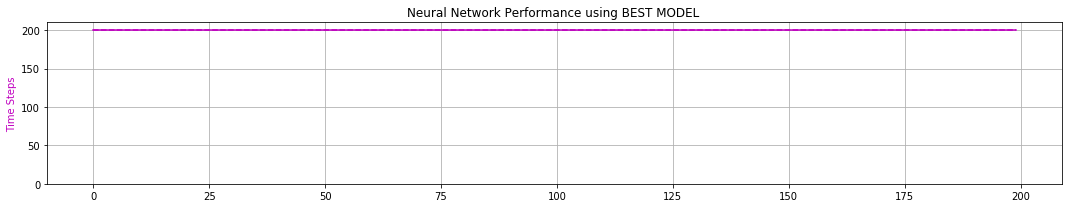

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED
UPDT Q: 0.46670303


ITERATION # 9
TABULAR EPSILON =  0.98
TABULAR LR      =  0.001
ORGN Q: 0.46670303
NODE#9 MAIN Q:0.46670303	NODE Q:0.46670452
NODE#6 MAIN Q:0.46670303	NODE Q:0.46670455
NODE#5 MAIN Q:0.46670303	NODE Q:0.46670455
NODE#2 MAIN Q:0.46670303	NODE Q:0.46670452
NODE#8 MAIN Q:0.46670303	NODE Q:0.46670455
NODE#7 MAIN Q:0.46670303	NODE Q:0.46670452
NODE#1 MAIN Q:0.46670303	NODE Q:0.46670455
NODE#4 MAIN Q:0.46670303	NODE Q:0.4667045
NODE#0 MAIN Q:0.46670303	NODE Q:0.46670455
NODE#3 MAIN Q:0.46670303	NODE Q:0.46670455
LARGEST TIMESTEP in ITERATION 9: 200
REAL TIME TO GENERATE 200000 EXPERIENCES:0:00:06.397648


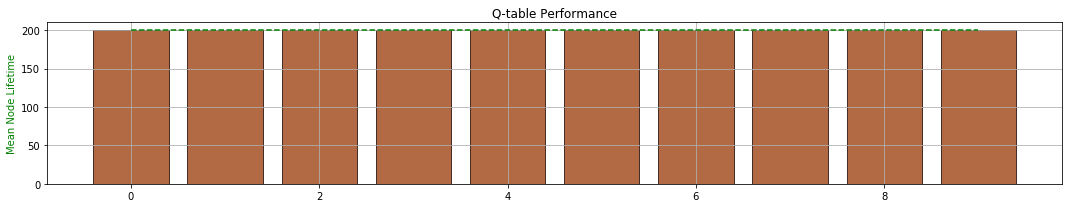

Problem SOLVED


In [17]:
iteration = 0
dqn = DQN()

v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# preloaded_dqn = DQN()
# preloaded_dqn.eval_net.load_state_dict(torch.load("./models/cartpole_nolimit.pt"))
# preloaded_dqn.eval_net.eval()
# Q_TABLE = preloaded_dqn.get_qvals(state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)

# Create a pool of processes
pool = mp.Pool(NO_OF_NODES)

while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()

    # Map aigym environment to each process
#     node_id = range(NO_OF_NODES)
#     args = [(Q_TABLE, n_id) for n_id in node_id]
#     print(args)
#     break
    print("ORGN Q:", Q_TABLE.mean())
    args = range(NO_OF_NODES)
    result = pool.map(mp_node_run, args)
    
    node_time_rec = np.array([item[1] for item in result])
    node_exp = np.array([item[0] for item in result ])
    all_exp = np.array([item for each_node_exp in node_exp 
                                for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,10)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(node_time_rec.sum().astype(int), (datetime.now()-tic)))

    #PLOT EXPERIENCES
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    if node_min_time.min() > 195:
        print("Problem SOLVED")
        break

    #segregate experiences
    good_mem = all_exp[all_exp[:,5] == 1]
    bad_mem  = all_exp[all_exp[:,5]  < 1]
#     dqn.good_memory = good_mem
#     dqn.bad_memory = bad_mem 
    if good_mem.shape[0] < BATCH_SIZE*100:
        dqn.good_memory = np.vstack((dqn.good_memory, good_mem))
    else:
        dqn.good_memory = good_mem
        
    if bad_mem.shape[0] < BATCH_SIZE*100:
        dqn.bad_memory = np.vstack((dqn.bad_memory, bad_mem))
    else:
        dqn.bad_memory = bad_mem

    #learn
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), RFILE +'_'+str(GRANULARITY))

    print("TRAINING TIME:{}".format(datetime.now()-tic))

#     best_dqn = DQN()
#     best_dqn.eval_net.load_state_dict(torch.load(RFILE +'_'+str(GRANULARITY)))
#     best_dqn.eval_net.eval()
    
    
    dqn.eval_net.load_state_dict(torch.load(RFILE +'_'+str(GRANULARITY)))
#     dqn.eval_net.load_state_dict(torch.load("./models/cartpole_nolimit.pt"))
    dqn.eval_net.eval()
    
    #test NN policy using BEST MODEL
    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()
        while True:
    #         env.render()
            time_step += 1 
            a = dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    print("DISCRETIZING THE Q-TABLE WITH BEST MODEL...")
   
    
#     old_Q = Q_TABLE.copy()
#     %time 
    Q_TABLE = dqn.get_qvals(state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)

    #NORMALIZING Q-TABLE
    Q_TABLE = -1 + 2.0 * (Q_TABLE-Q_TABLE.min())/(Q_TABLE.max() - Q_TABLE.min())

#     # PRINTING DIFFERENCE
#     print("DIFFERENCE:\n   MAX\t\t MIN\t\t MEAN\t\t STD")
#     diff_max   = old_Q.max() - Q_TABLE.max()
#     diff_min   = old_Q.min() - Q_TABLE.min()
#     diff_mean  = old_Q.mean() - Q_TABLE.mean()
#     diff_std   = old_Q.std() - Q_TABLE.std()
#     print("{:8.2f}\t{:8.2f}\t{:8.2f}\t{:8.2f}\t".format(diff_max, diff_min, diff_mean,diff_std))
    
    print("DISCRETIZING FINISHED")
    print("UPDT Q: "+ str(Q_TABLE.mean()))
    np.save("Q_TABLE_data", Q_TABLE)

    iteration += 1

pool.close()
pool.join()

In [18]:
# print("TESTING FINAL Q-TABLES...")
# test_node_times = mp.Queue()

# # Setup a list of processes that we want to run
# processes = [mp.Process(target=test_mp_node_run, args=(Q_TABLE,test_node_times)) for x in range(NO_OF_NODES)]

# # Run processes
# for p in processes:
#     p.start()

# # Exit the completed processes
# for p in processes:
#     p.join()

# # Get process results from the output queue
# node_time_rec = np.array([test_node_times.get() for p in processes]).astype(int)

# #PLOT EXPERIENCES
# node_avg_time = node_time_rec.mean(axis=1)
# node_std_time = node_time_rec.std(axis=1)
# node_max_time = node_time_rec.max(axis=1)
# node_min_time = node_time_rec.min(axis=1)

# fig = plt.figure(figsize = (15,3))
# ax2 = fig.add_subplot(1, 1, 1)
# ax2.set_title("Q-table Performance")
# ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
# ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
# ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

# ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
# ax2.set_ylabel('Mean Node Lifetime',color = 'g')
# ax2.set_ylim(0,TIMESTEP_LIMIT+10)
# fig.tight_layout()
# ax2.grid()
# plt.show()

In [19]:
# print("TOTAL SERIAL TIMESTEPS   : ", total_serial_timesteps)
# print("TOTAL PARALLEL TIMESTEPS : ", total_parallel_timesteps)
# print("SPEED UP PERCENTAGE      : ", total_serial_timesteps/total_parallel_timesteps)